<a href="https://colab.research.google.com/github/mnslarcher/cs224w-slides-to-code/blob/main/notebooks/03-node-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='red'>Disclaimer: this notebook is still a work in progress</font>

In [1]:
%pip install karateclub==1.2.2

# Node Embeddings

In [2]:
import random
import time
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import clear_output, display

In [3]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

# Random Walk

In [4]:
class RandomWalk:
    def __init__(
        self,
        G: nx.Graph,
        node_size: int = 1500,
        width: int = 2,
        font_size: int = 16,
        fig_size: Tuple[int, int] = (8, 6),
        seed: int = 42,
    ) -> None:
        self.G = G
        self.node_size = node_size
        self.width = width
        self.font_size = font_size
        self.fig_size = fig_size
        self.seed = seed

    def _draw(self, ax: plt.Axes) -> None:
        node_colors = [
            "tab:blue"
            if node == self.current_node
            else "tab:orange"
            if node == self.starting_node
            else "tab:gray"
            if node in self.visited_nodes
            else "white"
            for node in self.G.nodes
        ]
        edge_colors = ["tab:gray" if sorted(edge) in self.visited_edges else "black" for edge in self.G.edges]
        pos = nx.spring_layout(self.G, seed=self.seed)

        nx.draw(
            self.G,
            pos=pos,
            ax=ax,
            node_color=node_colors,
            edgecolors="black",
            edge_color=edge_colors,
            node_size=self.node_size,
            width=self.width,
            font_size=self.font_size,
            with_labels=True,
        )

    def run(self, num_steps: int = 5, sleep_seconds: float = 0.5) -> None:
        self.starting_node = random.choice(list(self.G.nodes))
        self.current_node = self.starting_node
        self.visited_nodes = [self.current_node]
        self.visited_edges = []
        title = f"Random walk ({num_steps} steps): {self.current_node}"

        fig = plt.gcf()
        ax = fig.gca()
        self._draw(ax)
        plt.title(title, fontsize=self.font_size, loc="left")
        display(fig)
        clear_output(wait=True)

        for _ in range(num_steps):
            previous_node = self.current_node
            self.current_node = random.choice(list(self.G.neighbors(previous_node)))
            self.visited_edges.append(sorted((previous_node, self.current_node)))
            self.visited_nodes.append(self.current_node)
            title += f" -> {self.current_node}"

            time.sleep(sleep_seconds)
            self._draw(ax)
            plt.title(title, fontsize=self.font_size, loc="left")
            display(fig)
            clear_output(wait=True)

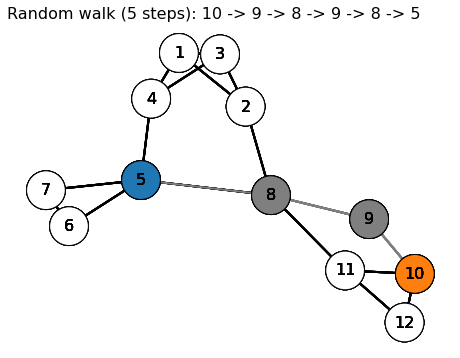

In [5]:
edge_list = [
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 3),
    (2, 8),
    (3, 4),
    (4, 5),
    (5, 6),
    (5, 7),
    (5, 8),
    (6, 7),
    (8, 9),
    (8, 11),
    (9, 10),
    (10, 11),
    (10, 12),
    (11, 12),
]
G = nx.Graph(edge_list)
random_walk = RandomWalk(G)

plt.figure(figsize=(8, 6))
random_walk.run()
plt.show()

# How should we randomly walk?

In [6]:
from karateclub import Estimator
from sklearn.cluster import KMeans

In [7]:
def node_embedding_method_example(
    G: nx.Graph, model: Estimator, n_clusters: int = 4, node_size: int = 500, font_size=16, seed: int = 42
) -> None:
    model.fit(G.copy())
    embeddings = model.get_embedding()
    labels = KMeans(n_clusters).fit_predict(embeddings)

    pos = nx.spring_layout(G, seed=seed)
    cmap = plt.get_cmap("tab10")
    node_colors = [cmap(label) for label in labels]

    nx.draw(G, pos=pos, node_color=node_colors, node_size=node_size, with_labels=True)
    plt.title(
        f"Colored nodes based on clusters identified by K-Means (K={n_clusters})\n on embeddings extracted with "
        f"{type(model).__name__}",
        fontsize=font_size,
    )

In [8]:
G = nx.karate_club_graph()

## DeepWalk

In [9]:
from karateclub import DeepWalk

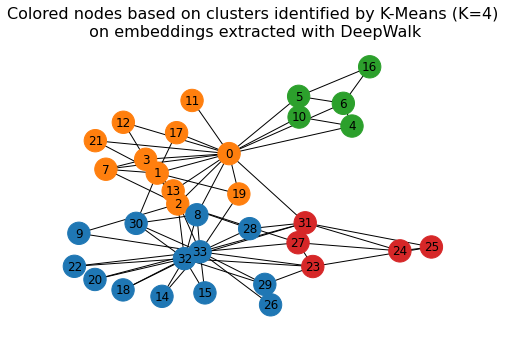

In [10]:
node_embedding_method_example(G, DeepWalk(dimensions=16))

## Node2Vec

In [11]:
from karateclub import Node2Vec

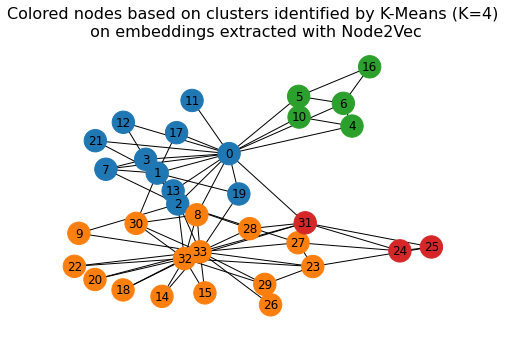

In [12]:
node_embedding_method_example(G, Node2Vec(dimensions=16))

# Embedding Entire Graphs

> The following part is an adaptation of a [tutorial](https://karateclub.readthedocs.io/en/latest/notes/introduction.html#graph-embedding) from the [Karate Club](https://karateclub.readthedocs.io/en/latest/index.html#) library

In [13]:
from karateclub.dataset import GraphSetReader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

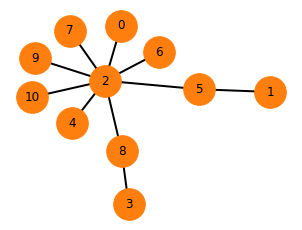

In [14]:
# The task is the classification of threads from the online forum Reddit. The threads can be of of two types -
# discussion and non-discussion based ones. Our goal is to predict the type of the thread based on the topological
# (structural) properties of the graphs. The specific dataset that we look a 10 thousand graph subsample of the Reddit
# 204K dataset which contains a large number of threads from the spring of 2018. The graphs in the dataset do not have
# a specific feature.

reader = GraphSetReader("reddit10k")

graphs = reader.get_graphs()[:1000]
y = reader.get_target()[:1000]

plt.figure(figsize=(4, 3))
nx.draw(graphs[0], node_color="tab:orange", node_size=1000, width=2, with_labels=True)

# Approach 1

In [15]:
def get_graph_embedding(G: nx.Graph, model: Estimator) -> np.ndarray:
    model.fit(G.copy())
    return model.get_embedding().sum(0)

In [16]:
X = np.vstack([get_graph_embedding(G, DeepWalk(dimensions=16))for G in tqdm(graphs)])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
downstream_model = LogisticRegression(random_state=42).fit(X_train, y_train)
y_hat = downstream_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_hat)
print(f"AUC: {auc:.4f}")

AUC: 0.6755


# Approach 2

# Approach 3